In [ ]:
!pip install transformers
!pip install datasets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from pathlib import Path
import os
import string
from datetime import datetime
import re
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from transformers import AutoTokenizer, DebertaTokenizer,DebertaModel, AutoModelForMaskedLM
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import torch
import numpy as np
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from pathlib import Path
import os
import string
from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset
from transformers import DefaultDataCollator,Trainer, TrainingArguments
import tensorflow as tf
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

from google.colab import drive
drive.mount("/content/drive")
PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


In [23]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")

In [ ]:
train.labels.value_counts()

2    5470
0    2720
3    1648
1      17
Name: labels, dtype: int64

In [25]:
train.drop(['label'],axis=1,inplace=True)
test.drop(['label'],axis=1,inplace=True)

In [6]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.sentence1[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.labels[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [26]:
# Creating the dataset and dataloader for the neural network

# train_size = 0.8
# train_dataset=df.sample(frac=train_size,random_state=200)
# test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
# train_dataset = train_dataset.reset_index(drop=True)

train_dataset = train
test_dataset = test


# print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

TRAIN Dataset: (9848, 2)
TEST Dataset: (1096, 2)


In [27]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [28]:
# Creating the customized model, by adding a drop out and a dense layer on top of roberta to get the final output for the model. 
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained("hfl/chinese-roberta-wwm-ext", output_hidden_states=True)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)


    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0] # 0
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        
        output = self.classifier(pooler)
        return output


In [29]:
model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [9]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch,training_loader):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)

        # Print the loss
        if _%10==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')


        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
# Train
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    train(epoch,training_loader)

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        tr_loss = 0
        n_correct = 0
        nb_tr_steps = 0
        nb_tr_examples = 0

        fin_targets=[]
        fin_outputs=[]

        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(big_idx.cpu().detach().numpy().tolist())
            
            if _%100==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu, fin_outputs, fin_targets

In [ ]:
acc, output, target = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss per 100 steps: 0.012792267836630344
Validation Accuracy per 100 steps: 100.0
Validation Loss per 100 steps: 0.5652505826841265
Validation Accuracy per 100 steps: 78.7128712871287
Validation Loss per 100 steps: 0.663928710375982
Validation Accuracy per 100 steps: 76.61691542288557
Validation Loss per 100 steps: 0.6205439836968764
Validation Accuracy per 100 steps: 78.07308970099668
Validation Loss per 100 steps: 0.6360496935234904
Validation Accuracy per 100 steps: 77.55610972568579
Validation Loss per 100 steps: 0.637717027965368
Validation Accuracy per 100 steps: 77.24550898203593
Validation Loss Epoch: 0.6369580836298733
Validation Accuracy Epoch: 77.55474452554745
Accuracy on test data = 77.55%


In [ ]:
target_names = ['Class 0','Class 1','Class 2','Class 3']
print(classification_report(target, output, target_names=target_names)) 

Using K-fold Cross-Validation

In [ ]:
df = train.append(test)
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

In [ ]:
# K = 5

EPOCHS = 1
n=5
kf = KFold(n_splits=n, random_state=42, shuffle=True)

target_names = ['Class 0','Class 1','Class 2','Class 3']

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }


results = []
test_df = pd.DataFrame()
count = 0
for train_index, val_index in kf.split(df):
    
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

    train_df.reset_index(inplace=True)
    val_df.reset_index(inplace=True)
    # val_df.drop(['index'],axis=1,inplace=True)

    training_set = Triage(train_df, tokenizer, MAX_LEN)
    testing_set = Triage(val_df, tokenizer, MAX_LEN)

    training_loader = DataLoader(training_set, **train_params)
    testing_loader = DataLoader(testing_set, **test_params)

    model = BERTClass()
    model.to(device)

    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

    # Train
    for epoch in range(EPOCHS):
       train(epoch,training_loader)

    # validate the model
    acc, output, target = valid(model, testing_loader)

    val_df['pred'] = output
    val_df['label'] = target
    test_df = test_df.append(val_df)

    filename = '/content/drive/MyDrive/roBERTa_pred ' + str(count) + '.csv'
    val_df.to_csv(filename)
    
    print(classification_report(target, output, target_names=target_names)) 
    
    # append model score
    results.append(acc)
    count = count+1


print("Accuracies",results)
print(f"Mean-Accuracy: {sum(results) / len(results)}")

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecate

Epoch: 0, Loss:  1.4049855470657349
Training Loss per 5000 steps: 1.4049855470657349
Training Accuracy per 5000 steps: 25.0
Epoch: 0, Loss:  1.2679215669631958
Epoch: 0, Loss:  1.1131174564361572
Epoch: 0, Loss:  1.0608878135681152
Epoch: 0, Loss:  0.8317105174064636
Epoch: 0, Loss:  1.267134666442871
Epoch: 0, Loss:  1.1498537063598633
Epoch: 0, Loss:  0.9942531585693359
Epoch: 0, Loss:  0.8704236745834351
Epoch: 0, Loss:  0.9162319302558899
Epoch: 0, Loss:  0.6327064037322998
Epoch: 0, Loss:  0.990065336227417
Epoch: 0, Loss:  0.9314919710159302
Epoch: 0, Loss:  0.9093220233917236
Epoch: 0, Loss:  0.972021222114563
Epoch: 0, Loss:  1.1374906301498413
Epoch: 0, Loss:  0.8717527985572815
Epoch: 0, Loss:  0.6268013715744019
Epoch: 0, Loss:  0.5785354375839233
Epoch: 0, Loss:  0.8129225969314575
Epoch: 0, Loss:  0.6316009759902954
Epoch: 0, Loss:  0.9903345108032227
Epoch: 0, Loss:  1.087793231010437
Epoch: 0, Loss:  1.0835700035095215
Epoch: 0, Loss:  0.8210592269897461
Epoch: 0, Loss: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 0, Loss:  1.4028533697128296
Training Loss per 5000 steps: 1.4028533697128296
Training Accuracy per 5000 steps: 25.0
Epoch: 0, Loss:  1.198911428451538
Epoch: 0, Loss:  1.20033597946167
Epoch: 0, Loss:  1.0046391487121582
Epoch: 0, Loss:  0.9027448892593384
Epoch: 0, Loss:  1.0365583896636963
Epoch: 0, Loss:  0.9929145574569702
Epoch: 0, Loss:  1.0207641124725342
Epoch: 0, Loss:  1.074660062789917
Epoch: 0, Loss:  1.2868115901947021
Epoch: 0, Loss:  0.9680845737457275
Epoch: 0, Loss:  0.7099467515945435
Epoch: 0, Loss:  0.8960089683532715
Epoch: 0, Loss:  1.0325143337249756
Epoch: 0, Loss:  0.7750405073165894
Epoch: 0, Loss:  1.1489955186843872
Epoch: 0, Loss:  0.9151263236999512
Epoch: 0, Loss:  1.2359066009521484
Epoch: 0, Loss:  0.8581658601760864
Epoch: 0, Loss:  0.9181987643241882
Epoch: 0, Loss:  0.9541993737220764
Epoch: 0, Loss:  0.9397975206375122
Epoch: 0, Loss:  0.8184528946876526
Epoch: 0, Loss:  0.4347779154777527
Epoch: 0, Loss:  1.1905591487884521
Epoch: 0, Loss: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 0, Loss:  1.4323927164077759
Training Loss per 5000 steps: 1.4323927164077759
Training Accuracy per 5000 steps: 12.5
Epoch: 0, Loss:  1.014241099357605
Epoch: 0, Loss:  0.8830175399780273
Epoch: 0, Loss:  1.1234556436538696
Epoch: 0, Loss:  1.2128710746765137
Epoch: 0, Loss:  1.41989266872406
Epoch: 0, Loss:  1.1493496894836426
Epoch: 0, Loss:  1.0012837648391724
Epoch: 0, Loss:  0.7589383125305176
Epoch: 0, Loss:  1.0640316009521484
Epoch: 0, Loss:  0.7778595685958862
Epoch: 0, Loss:  0.7604613304138184
Epoch: 0, Loss:  0.6856629848480225
Epoch: 0, Loss:  0.8927116990089417
Epoch: 0, Loss:  0.7276875376701355
Epoch: 0, Loss:  0.661234438419342
Epoch: 0, Loss:  0.6843481659889221
Epoch: 0, Loss:  0.7545230984687805
Epoch: 0, Loss:  0.7602732181549072
Epoch: 0, Loss:  0.8617240786552429
Epoch: 0, Loss:  0.8980875015258789
Epoch: 0, Loss:  0.5230607390403748
Epoch: 0, Loss:  0.495273232460022
Epoch: 0, Loss:  0.5332427620887756
Epoch: 0, Loss:  0.589112401008606
Epoch: 0, Loss:  0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 0, Loss:  1.2033993005752563
Training Loss per 5000 steps: 1.2033993005752563
Training Accuracy per 5000 steps: 50.0
Epoch: 0, Loss:  1.1162371635437012
Epoch: 0, Loss:  0.9392037391662598
Epoch: 0, Loss:  0.8433160781860352
Epoch: 0, Loss:  0.8152128458023071
Epoch: 0, Loss:  1.0051625967025757
Epoch: 0, Loss:  1.0583667755126953
Epoch: 0, Loss:  1.2624034881591797
Epoch: 0, Loss:  0.830329954624176
Epoch: 0, Loss:  0.9778563976287842
Epoch: 0, Loss:  0.8361389636993408
Epoch: 0, Loss:  1.227297067642212
Epoch: 0, Loss:  1.1933553218841553
Epoch: 0, Loss:  0.4526117742061615
Epoch: 0, Loss:  1.1243540048599243
Epoch: 0, Loss:  0.8932110667228699
Epoch: 0, Loss:  0.7819905281066895
Epoch: 0, Loss:  1.2123433351516724
Epoch: 0, Loss:  0.7507728934288025
Epoch: 0, Loss:  1.0481197834014893
Epoch: 0, Loss:  0.8431450128555298
Epoch: 0, Loss:  0.6680802702903748
Epoch: 0, Loss:  0.7407795190811157
Epoch: 0, Loss:  0.8820470571517944
Epoch: 0, Loss:  0.641596794128418
Epoch: 0, Loss:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 0, Loss:  1.3112125396728516
Training Loss per 5000 steps: 1.3112125396728516
Training Accuracy per 5000 steps: 50.0
Epoch: 0, Loss:  1.0539805889129639
Epoch: 0, Loss:  0.9311455488204956
Epoch: 0, Loss:  0.9289553165435791
Epoch: 0, Loss:  1.113645076751709
Epoch: 0, Loss:  1.0239996910095215
Epoch: 0, Loss:  1.1859532594680786
Epoch: 0, Loss:  0.8523035645484924
Epoch: 0, Loss:  0.9743776917457581
Epoch: 0, Loss:  1.0916342735290527
Epoch: 0, Loss:  0.8152244687080383
Epoch: 0, Loss:  1.0384938716888428
Epoch: 0, Loss:  0.6098775267601013
Epoch: 0, Loss:  0.8780441880226135
Epoch: 0, Loss:  1.0414550304412842
Epoch: 0, Loss:  0.717318058013916
Epoch: 0, Loss:  0.9026201963424683
Epoch: 0, Loss:  0.9809895753860474
Epoch: 0, Loss:  0.7293487191200256
Epoch: 0, Loss:  0.7036356329917908
Epoch: 0, Loss:  0.9868099689483643
Epoch: 0, Loss:  0.9470603466033936
Epoch: 0, Loss:  1.1261603832244873
Epoch: 0, Loss:  0.6405998468399048
Epoch: 0, Loss:  0.5385233759880066
Epoch: 0, Loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

     unknown       0.83      0.55      0.66       597
   unrelated       0.00      0.00      0.00         3
    anti_ccp       0.78      0.92      0.85      1217
     pro_ccp       0.66      0.65      0.65       373

    accuracy                           0.77      2190
   macro avg       0.57      0.53      0.54      2190
weighted avg       0.77      0.77      0.76      2190

Accuracies [78.73117298037425, 77.30593607305936, 75.47945205479452, 76.02739726027397, 77.12328767123287]
Mean-Accuracy: 76.933449207947


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(test_df['labels'].astype(int), test_df['pred'].astype(int), target_names=target_names)) 

In [ ]:
# Saving the files for re-use

output_model_file = os.path.join(PATH,'roberta_model.bin')

model_to_save = model
torch.save(model_to_save, output_model_file)

T-SNE on BERT embeddings

In [10]:
import numpy as np, pandas as pd 
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt1
%matplotlib inline

In [11]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained("hfl/chinese-roberta-wwm-ext")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output, hidden_state

In [12]:
output_model_file = os.path.join(PATH,'roberta_model.bin')
model = torch.load(output_model_file,map_location=device)
# model.to(device)

In [13]:
# Defining some key variables 
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")

In [14]:
test = pd.read_csv("/content/drive/MyDrive/test.csv")
test = test.sample(frac = 1)

test_params = {'batch_size': 8,
                'shuffle': False,
                'num_workers': 0
                }
testing_set = Triage(test, tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, **test_params)

<ipython-input-14-723f22f9aeac>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['labels'][i]=2
<ipython-input-14-723f22f9aeac>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['labels'][i]=3


In [15]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        tr_loss = 0
        n_correct = 0
        nb_tr_steps = 0
        nb_tr_examples = 0

        fin_targets=[]
        fin_outputs=[]
        output=[]

        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs, hidden_states = model(ids, mask)#.squeeze()
            outputs = outputs.squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(big_idx.cpu().detach().numpy().tolist())
            output.extend(hidden_states.cpu().detach().numpy().tolist())
            
            if _%100==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu, fin_outputs, fin_targets, output

In [16]:
acc, output, target, outputs = valid(model, testing_loader)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Loss per 100 steps: 0.33358797430992126
Validation Accuracy per 100 steps: 75.0
Validation Loss Epoch: 0.6821969158234115
Validation Accuracy Epoch: 75.0


In [ ]:
len(outputs)

376

In [ ]:
len(outputs[0])

512

In [ ]:
len(np.mean(np.array(outputs[0]), axis=0))

768

In [17]:
for i in range(len(outputs)):
  a = np.array(outputs[i])
  outputs[i] = np.mean(a, axis=0)

In [ ]:
test['embed'] = outputs
test['pred'] = output
for i in range(len(test)):
  if (test['pred'][i]==test['labels'][i]):
    test['pred'][i] = 'Correct'
  else: test['pred'][i] = 'Incorect'

In [19]:
mat = np.matrix([x for x in test.embed])
mat

matrix([[-0.17964829,  0.45895978, -0.30944616, ..., -0.20941   ,
         -0.03606091, -0.26292854],
        [-0.16237572, -0.23508959, -0.21785636, ..., -0.0716263 ,
          0.74665097, -0.11887671],
        [-0.38485365, -0.46240689, -0.37255814, ..., -0.00675655,
          0.58123369, -0.04950045],
        ...,
        [ 0.35211285, -0.42346645, -0.39507699, ...,  0.25238242,
         -0.1043053 , -0.57846701],
        [-0.26843012, -0.40763218, -0.57446761, ..., -0.42490765,
         -0.06194103, -0.22395639],
        [ 0.20086399, -0.31065371, -0.49248316, ...,  0.20386869,
         -0.22325327, -0.50347396]])

In [ ]:
mat.shape

(376, 768)

In [20]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2) 
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Lower dim data has shape (376, 2)


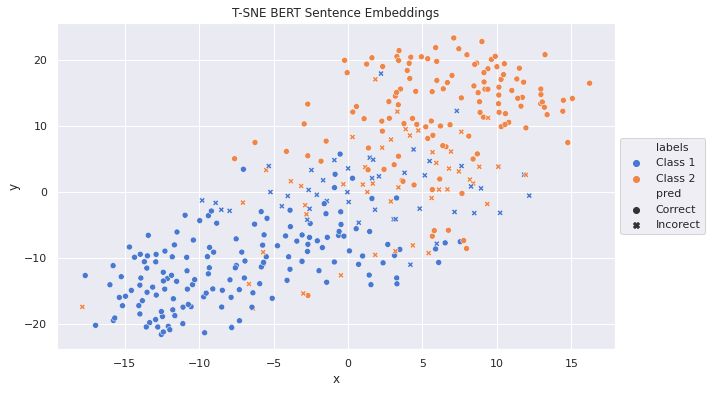

In [22]:
df = test
tsne_df =  pd.DataFrame(low_dim_data, df.iloc[:low_dim_data.shape[0]].labels.replace({1:'Class 1',2:'Class 2'}))
tsne_df.columns = ['x','y']
tsne_df['pred'] = list(df['pred'])
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index, style = tsne_df.pred,)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax.set_title('T-SNE BERT Sentence Embeddings')
plt1.show()